In [1]:
# NEW VERSION 
# To implement the ensemble optimization based on the stratified C-index, we need to modify the 
# SurvivalModel class to include functionality for calculating the stratified C-index and optimizing 
# the weights for the ensemble. Here's how you can modify your code:
# - Add a method to calculate the stratified C-index.
# - Add a method to optimize the weights based on the stratified C-index.
# - Modify the predict method to use the optimized weights.

<div style="background-color: #f5f5f5; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        IMPORTS AND INSTALLATION
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        This section includes all the necessary imports and installations required for the project.
    </p>
</div>

In [2]:
# Install required libraries from Kaggle input directory
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8021090ceee569e788230ede6e18e60a18b9292ce41947e0cada32beeb320f41
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [3]:
# Import standard libraries
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from typing import Tuple, List, Dict

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import scientific computing libraries
from scipy.stats import rankdata
from scipy.optimize import minimize

# Import scikit-learn libraries for model selection, preprocessing, and evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor


# Import machine learning frameworks
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor  # Importing the Cox model implementation (CatBoost can be used for Cox model)
import xgboost as xgb
from xgboost import XGBRegressor

# Import survival analysis libraries
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) # Set the maximum number of columns to display
pd.set_option('display.width', None) # Set the width of the display



<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        CONFIGURATION CLASS (Config)
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The <code>Config</code> class contains all the necessary configurations for the project, including paths, model parameters, and protected attributes for fairness monitoring.
    </p>
    <h3 style="color: #6a0dad; font-family: 'Georgia', serif; font-size: 20px; margin-top: 15px;">
        Key Components:
    </h3>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Paths:</strong> File paths for training, testing, and submission data.</li>
        <li><strong>Model Parameters:</strong> Settings for LightGBM and Cox models, including hyperparameters and fairness-related attributes.</li>
        <li><strong>Protected Attributes:</strong> Attributes like <code>race_group</code>, <code>ethnicity</code>, and <code>sex</code> are monitored to ensure fairness in predictions.</li>
    </ul>
    <h3 style="color: #6a0dad; font-family: 'Georgia', serif; font-size: 20px; margin-top: 15px;">
</div>

In [4]:
class Config:
    """Configuration class containing model parameters and paths."""

    # Debug mode
    DEBUG = False  # Set to False for FULL RUN
    
    # Paths
    TRAIN_PATH = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
    TEST_PATH = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
    SUBMISSION_PATH = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
    
    # Model parameters
    N_SPLITS = 5
    RANDOM_STATE = 42
    
    # LightGBM parameters
    LGBM_PARAMS = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'n_estimators': 5000 if not DEBUG else 100,  # Reduce number of estimators in debug mode
        'learning_rate': 0.05,
        'num_leaves': 64 if not DEBUG else 16,  # Reduce number of leaves in debug mode
        'max_depth': 10 if not DEBUG else 5,  # Reduce max depth in debug mode
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'metric': 'rmse',
        'early_stopping_round': 150 if not DEBUG else 50,  # Reduce early stopping rounds in debug mode
        'verbose': -1
    }


    # Random Forest parameters
    RF_PARAMS = {
        'n_estimators': 3000 if not DEBUG else 100,  # Reduce number of trees in debug mode
        'max_depth': 20 if not DEBUG else 10,  # Reduce max depth in debug mode
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',  # Number of features to consider at each split
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }

    # XGBoost parameters
    XGB_PARAMS = {
        'n_estimators': 5000 if not DEBUG else 100,  # Reduce number of trees in debug mode
        'max_depth': 10 if not DEBUG else 6,  # Reduce max depth in debug mode
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'early_stopping_rounds': 100,  # Early stopping
        'n_jobs': -1,
        'verbose': False  # Suppress training progress messages

    }
    
    # Cox model parameters (using CatBoost with 'Cox' loss function)
    COX1_PARAMS = {
        'grow_policy': 'Depthwise',
        'min_child_samples': 8,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': RANDOM_STATE,
        'task_type': 'CPU',
        'num_trees': 6000 if not DEBUG else 100,  # Reduce number of trees in debug mode
        'subsample': 0.6,
        'reg_lambda': 8.0,
        'depth': 8 if not DEBUG else 4,  # Reduce depth in debug mode
        'early_stopping_rounds': 100,  # Early stopping
        'verbose': False  # Reduces verbosity
    }
    
    COX2_PARAMS = {
        'grow_policy': 'Lossguide',
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': RANDOM_STATE,
        'task_type': 'CPU',
        'num_trees': 6000 if not DEBUG else 100,  # Reduce number of trees in debug mode
        'subsample': 0.6,
        'reg_lambda': 8.0,
        'num_leaves': 32 if not DEBUG else 16,  # Reduce number of leaves in debug mode
        'depth': 8 if not DEBUG else 4,  # Reduce depth in debug mode
        'early_stopping_rounds': 100,  # Early stopping
        'verbose': False  # Reduces verbosity
    }
    
    COX3_PARAMS = {
        'grow_policy': 'Depthwise',
        'min_child_samples': 16,
        'loss_function': 'Cox',
        'learning_rate': 0.02,
        'random_state': RANDOM_STATE,
        'task_type': 'CPU',
        'num_trees': 7000 if not DEBUG else 100,  # Reduce number of trees in debug mode
        'subsample': 0.5,
        'reg_lambda': 6.0,
        'depth': 10 if not DEBUG else 4,  # Reduce depth in debug mode
        'early_stopping_rounds': 100,  # Early stopping
        'verbose': False  # Reduces verbosity
    }





# Helper Functions


In [5]:
def bin_continuous_target(y, n_bins=10):
    """Bin a continuous target into discrete categories for stratification."""
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

In [6]:
def stratified_c_index(y_true, y_pred, race_groups):
    """
    Calculate the stratified C-index for each racial group and return the mean minus the standard deviation.
    """
    c_indices = {}
    
    # Calculate C-index for each racial group
    for race in race_groups.unique():
        mask = race_groups == race
        c_index = concordance_index(y_true[mask], y_pred[mask])
        c_indices[race] = c_index
    
    # Calculate mean and standard deviation of C-indices
    mean_c_index = np.mean(list(c_indices.values()))
    std_c_index = np.std(list(c_indices.values()))
    
    # Stratified C-index is mean minus standard deviation
    stratified_c_index = mean_c_index - std_c_index
    
    return stratified_c_index, c_indices

<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        DATA PREPROCESSING CLASS (DataPreprocessor)
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The <code>DataPreprocessor</code> class handles all data preprocessing tasks, ensuring the data is clean, encoded, and scaled for modeling. Key functionalities include:
    </p>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Loading Data:</strong> Reads data from CSV files using <code>load_data</code>.</li>
        <li><strong>Handling Missing Values:</strong> Imputes missing numerical values with race-specific medians and fills categorical missing values with <code>'Unknown'</code>.</li>
        <li><strong>Encoding Categorical Variables:</strong> Uses <code>LabelEncoder</code> to transform categorical columns into numerical values.</li>
        <li><strong>Scaling Numerical Variables:</strong> Applies <code>StandardScaler</code> to normalize numerical features, excluding specific columns like <code>ID</code>, <code>efs</code>, and <code>efs_time</code>.</li>
    </ul>
</div>

In [7]:
class DataPreprocessor:
    """Class for handling data preprocessing tasks."""
    
    def __init__(self, config):
        self.config = config  # Store config as an attribute
        self.scalers = {}
        self.label_encoders = {}
        
    def load_data(self, path: Path) -> pd.DataFrame:
        if self.config.DEBUG:
            print("     🚀 DEBUG MODE: Loading only 100 rows for debugging")
            return pd.read_csv(path).head(100)
        else:
            return pd.read_csv(path)
    
    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle missing values in the dataset with race-specific imputation and missing value flags."""
        
        # Handle numerical columns with race-specific imputation
        num_cols = df.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            if df[col].isnull().any():                
                # Impute missing values with race-specific medians
                df[col] = df.groupby('race_group')[col].transform(lambda x: x.fillna(x.median()))
                
                # If there are still missing values (e.g., if a race group has all missing values), fill with global median
                df[col] = df[col].fillna(df[col].median())
        
        # Handle categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in cat_cols:
            if df[col].isnull().any():                
                # Fill missing categorical values with 'Unknown'
                df[col] = df[col].fillna('Unknown')
        
        return df
    
    def encode_categorical(self, df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
        """Encode categorical variables using LabelEncoder."""
        cat_cols = df.select_dtypes(include=['object']).columns
        
        # Ensure 'age_group' is included in categorical columns
        if 'age_group' in df.columns and 'age_group' not in cat_cols:
            cat_cols = cat_cols.append(pd.Index(['age_group']))
        
        for col in cat_cols:
            if col == 'age_group':
                # Handle 'age_group' as a categorical feature
                if train:
                    # Add 'Unknown' as a valid category during training
                    df[col] = df[col].astype('category')
                    df[col] = df[col].cat.add_categories('Unknown')
                    df[col] = df[col].fillna('Unknown')
                    # Encode categories as numerical codes
                    self.label_encoders[col] = dict(zip(df[col].cat.categories, range(len(df[col].cat.categories))))
                    df[col] = df[col].cat.codes
                else:
                    # For test data, ensure 'Unknown' and -1 are valid categories
                    df[col] = df[col].astype('category')
                    if 'Unknown' not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories('Unknown')
                    if -1 not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories(-1)
                    df[col] = df[col].fillna('Unknown')
                    # Map categories to numerical codes using the encoding from training
                    df[col] = df[col].map(self.label_encoders[col]).fillna(-1).astype(int)
            else:
                if train:
                    self.label_encoders[col] = LabelEncoder()
                    df[col] = self.label_encoders[col].fit_transform(df[col].fillna('Unknown'))
                else:
                    df[col] = df[col].fillna('Unknown')
                    unique_cats = self.label_encoders[col].classes_
                    df[col] = df[col].map(lambda x: 'Unknown' if x not in unique_cats else x)
                    df[col] = self.label_encoders[col].transform(df[col])
        
        return df
    
    def scale_numerical(self, df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns
        num_cols = [col for col in num_cols if col not in ['ID', 'efs', 'efs_time', 'age_at_hct_binned', 'karnofsky_score_binned', 'efs_time_group']]
        
        if train:
            for col in num_cols:
                self.scalers[col] = StandardScaler()
                df[col] = self.scalers[col].fit_transform(df[[col]])
        else:
            for col in num_cols:
                df[col] = self.scalers[col].transform(df[[col]])
        
        return df



<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        FEATURE ENGINEERING CLASS (FeatureEngineer)
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The <code>FeatureEngineer</code> class is responsible for creating new features from the dataset to improve model performance. Key functionalities include:
    </p>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Medical Features:</strong> Creates features like age difference, HLA compatibility score, and comorbidity interactions.</li>
        <li><strong>Socioeconomic Features:</strong> Builds composite indicators for socioeconomic status, healthcare access, and cultural compatibility.</li>
        <li><strong>Demographic Interactions:</strong> Generates interaction features between race, ethnicity, and gender for fairness monitoring.</li>
        <li><strong>Pipeline Execution:</strong> Runs a complete feature engineering pipeline to prepare the dataset for modeling.</li>
    </ul>
</div>

In [8]:
class FeatureEngineer:
    """Class for feature engineering."""
    
    def __init__(self, df: pd.DataFrame, is_test: bool = False):
        self.df = df
        self.is_test = is_test  # Flag to identify if the dataset is for testing

    def create_age_diff(self):
        """Create feature: Age difference between recipient and donor."""
        if 'age_at_hct' in self.df.columns and 'donor_age' in self.df.columns:
            self.df['age_diff'] = self.df['age_at_hct'] - self.df['donor_age']
    
    def create_hla_compatibility_score(self):
        """Create feature: HLA compatibility score based on high-resolution matching."""
        if all(col in self.df.columns for col in ['hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high', 'hla_match_drb1_high', 'hla_match_dqb1_high']):
            self.df['hla_compatibility_score'] = (
                self.df['hla_match_a_high'] + self.df['hla_match_b_high'] + 
                self.df['hla_match_c_high'] + self.df['hla_match_drb1_high'] + 
                self.df['hla_match_dqb1_high']
            )
    
    def create_comorbidity_kps_interaction(self):
        """Create feature: Interaction between comorbidity score and Karnofsky score."""
        if 'comorbidity_score' in self.df.columns and 'karnofsky_score' in self.df.columns:
            self.df['comorbidity_kps_interaction'] = self.df['comorbidity_score'] * self.df['karnofsky_score']
    
    

    def create_primary_disease_hla_match_interaction(self):
        """Create feature: Interaction between primary disease and HLA matching."""
        if 'prim_disease_hct' in self.df.columns and 'hla_match_a_high' in self.df.columns:
            self.df['primary_disease_hla_match_interaction'] = (
                (self.df['prim_disease_hct'] == 'AML').astype(int) * (self.df['hla_match_a_high'] > 0).astype(int)
            )
    
    def create_time_since_transplant(self):
        """Create feature: Time since the transplant (in years)."""
        if 'year_hct' in self.df.columns:
            self.df['time_since_transplant'] = 2025 - self.df['year_hct']  # Assume current year is 2025
    
    def create_primary_disease_group(self):
        """Create feature: Group primary diseases into broader categories."""
        if 'prim_disease_hct' in self.df.columns:
            self.df['primary_disease_group'] = self.df['prim_disease_hct'].map({
                'AML': 'Leukemia', 'ALL': 'Leukemia', 'MPN': 'Leukemia',
                'NHL': 'Lymphoma', 'PCD': 'Lymphoma', 'MDS': 'Leukemia',
                'SAA': 'Aplastic Anemia', 'Other acute leukemia': 'Leukemia', 
                'Other': 'Other'
            })
    
    def create_conditioning_intensity_encoded(self):
        """Create feature: Encoded conditioning intensity levels."""
        if 'conditioning_intensity' in self.df.columns:
            self.df['conditioning_intensity_encoded'] = self.df['conditioning_intensity'].map({
                'RIC': 0, 'NMA': 1, 'MAC': 2, 'TBD': -1, 'No drugs reported': -1, 'N/A, F(pre-TED) not submitted': -1
            }).fillna(-1)

    def create_socioeconomic_indicators(self):
        """Create composite socioeconomic indicators."""
        # Combine insurance status, education level, and employment
        if all(col in self.df.columns for col in ['insurance_status', 'education_level', 'employment_status']):
            self.df['socioeconomic_score'] = (
                self.df['insurance_status'].map({'Private': 3, 'Public': 2, 'None': 1}) +
                self.df['education_level'].map({'College': 3, 'High School': 2, 'Less than HS': 1}) +
                self.df['employment_status'].map({'Employed': 3, 'Unemployed': 1, 'Retired': 2})
            )
    
    def create_healthcare_access_score(self):
        """Create healthcare access composite score."""
        # Combine distance to center, urban/rural status, and transportation access
        if all(col in self.df.columns for col in ['distance_to_center', 'urban_rural', 'transportation_access']):
            self.df['healthcare_access_score'] = (
                self.df['distance_to_center'] * -0.1 +  # Further distance reduces access
                self.df['urban_rural'].map({'Urban': 2, 'Suburban': 1, 'Rural': 0}) +
                self.df['transportation_access'].map({'Good': 2, 'Limited': 1, 'Poor': 0})
            )
    
    def create_cultural_compatibility_score(self):
        """Create cultural compatibility indicators."""
        # Consider language match, cultural competency programs
        if all(col in self.df.columns for col in ['language_match', 'cultural_support']):
            self.df['cultural_compatibility'] = (
                self.df['language_match'].map({'Yes': 2, 'Partial': 1, 'No': 0}) +
                self.df['cultural_support'].map({'Available': 2, 'Limited': 1, 'None': 0})
            )
    
    def create_support_network_score(self):
        """Create support network strength indicator."""
        # Combine family support, community resources, and social services
        support_columns = ['family_support', 'community_resources', 'social_services']
        if all(col in self.df.columns for col in support_columns):
            self.df['support_network_score'] = self.df[support_columns].sum(axis=1)

    def create_basic_features(self):
        """Create basic medical and demographic features."""
        # Age-related features
        if 'age_at_hct' in self.df.columns and 'donor_age' in self.df.columns:
            self.df['age_diff'] = self.df['age_at_hct'] - self.df['donor_age']
            self.df['age_ratio'] = self.df['age_at_hct'] / self.df['donor_age']
        
        # HLA matching features
        hla_cols = ['hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high', 
                   'hla_match_drb1_high', 'hla_match_dqb1_high']
        if all(col in self.df.columns for col in hla_cols):
            self.df['hla_total_match'] = self.df[hla_cols].sum(axis=1)
            self.df['hla_mismatch_count'] = len(hla_cols) - self.df['hla_total_match']
    
    def create_medical_risk_scores(self):
        """Create composite medical risk scores."""
        # Comorbidity interaction score
        risk_factors = ['diabetes', 'obesity', 'hypertension', 'heart_disease', 
                       'liver_disease', 'renal_issue']
        if all(rf in self.df.columns for rf in risk_factors):
            self.df['comorbidity_count'] = self.df[risk_factors].apply(
                lambda x: sum(x == 'Yes'), axis=1
            )
        
        # Disease severity score
        if 'disease_stage' in self.df.columns and 'karnofsky_score' in self.df.columns:
            self.df['severity_score'] = (
                self.df['disease_stage'].map({'Early': 1, 'Intermediate': 2, 'Advanced': 3}) *
                (100 - self.df['karnofsky_score']) / 100
            )
    

    def create_demographic_interactions(self):
        """Create interaction features between demographic variables."""
        if all(col in self.df.columns for col in ['race_group', 'ethnicity', 'sex']):
            # Race-ethnicity interaction
            self.df['race_ethnicity'] = self.df['race_group'].astype(str) + "_" + self.df['ethnicity'].astype(str)
            
            # Gender-race interaction
            self.df['gender_race'] = self.df['sex'].astype(str) + "_" + self.df['race_group'].astype(str)
    
    def create_socioeconomic_features(self):
        """Create features related to socioeconomic status."""
        # Create age groups
        if 'age_at_hct' in self.df.columns:
            self.df['age_group'] = pd.qcut(self.df['age_at_hct'], q=5, 
                                         labels=['very_young', 'young', 'middle', 'senior', 'elderly'])
        
        # Create distance-based access feature
        if 'distance_to_center' in self.df.columns:
            self.df['center_access'] = np.where(self.df['distance_to_center'] <= 50, 'local',
                                     np.where(self.df['distance_to_center'] <= 150, 'regional', 'remote'))
    
    def create_treatment_equity_features(self):
        """Create features related to treatment equity."""
        if all(col in self.df.columns for col in ['wait_time', 'insurance_type', 'center_type']):
            # Create waiting time groups
            self.df['wait_time_group'] = pd.qcut(self.df['wait_time'], q=3, 
                                               labels=['short', 'medium', 'long'])
            
            # Insurance-center interaction
            self.df['insurance_center'] = self.df['insurance_type'].astype(str) + "_" + \
                                        self.df['center_type'].astype(str)

    def create_polynomial_features(self):
        """Create polynomial features for numerical variables."""
        if 'age_at_hct' in self.df.columns:
            self.df['age_at_hct_squared'] = self.df['age_at_hct'] ** 2
        if 'comorbidity_score' in self.df.columns:
            self.df['comorbidity_score_squared'] = self.df['comorbidity_score'] ** 2
    
    def create_interaction_terms(self):
        """Create interaction terms between key features."""
        if 'age_at_hct' in self.df.columns and 'karnofsky_score' in self.df.columns:
            self.df['age_karnofsky_interaction'] = self.df['age_at_hct'] * self.df['karnofsky_score']
        if 'comorbidity_score' in self.df.columns and 'karnofsky_score' in self.df.columns:
            self.df['comorbidity_karnofsky_interaction'] = self.df['comorbidity_score'] * self.df['karnofsky_score']

    def create_time_since_diagnosis(self):
        """Create feature: Time since diagnosis (in years)."""
        if 'year_of_diagnosis' in self.df.columns:
            self.df['time_since_diagnosis'] = 2025 - self.df['year_of_diagnosis']  # Assuming current year is 2025

    def apply_log_transformations(self):
        """Apply log transformations to skewed numerical features."""
        if 'efs_time' in self.df.columns:
            self.df['log_efs_time'] = np.log1p(self.df['efs_time'])  # log(1 + x) to handle zero values
        if 'comorbidity_score' in self.df.columns:
            self.df['log_comorbidity_score'] = np.log1p(self.df['comorbidity_score'])

    def bin_continuous_variables(self):
        """Bin continuous variables into discrete categories."""
        if 'age_at_hct' in self.df.columns:
            self.df['age_at_hct_binned'] = pd.cut(
                self.df['age_at_hct'], 
                bins=[0, 18, 40, 60, 100], 
                labels=['0-18', '18-40', '40-60', '60+']
            )
        if 'karnofsky_score' in self.df.columns:
            self.df['karnofsky_score_binned'] = pd.cut(
                self.df['karnofsky_score'], 
                bins=[0, 50, 70, 90, 100], 
                labels=['0-50', '50-70', '70-90', '90-100']
            )

    def create_disease_severity_score(self):
        """Create a composite disease severity score."""
        if 'disease_stage' in self.df.columns and 'karnofsky_score' in self.df.columns:
            self.df['disease_severity_score'] = (
                self.df['disease_stage'].map({'Early': 1, 'Intermediate': 2, 'Advanced': 3}) *
                (100 - self.df['karnofsky_score']) / 100
            )

    def create_hla_mismatch_count(self):
        """Create feature: Count of HLA mismatches."""
        hla_cols = ['hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high', 
                    'hla_match_drb1_high', 'hla_match_dqb1_high']
        if all(col in self.df.columns for col in hla_cols):
            self.df['hla_mismatch_count'] = len(hla_cols) - self.df[hla_cols].sum(axis=1)

    def create_race_comorbidity_interaction(self):
        """Create interaction feature between race and comorbidity."""
        if 'race_group' in self.df.columns and 'comorbidity_score' in self.df.columns:
            self.df['race_comorbidity_interaction'] = self.df['race_group'].astype(str) + "_" + self.df['comorbidity_score'].astype(str)


    def create_donor_recipient_age_ratio(self):
        """Create feature: Donor age to recipient age ratio."""
        if 'donor_age' in self.df.columns and 'age_at_hct' in self.df.columns:
            self.df['donor_recipient_age_ratio'] = self.df['donor_age'] / self.df['age_at_hct']

    def create_cumulative_risk_score(self):
        """Create a cumulative risk score combining multiple risk factors."""
        if all(col in self.df.columns for col in ['comorbidity_score', 'disease_stage', 'karnofsky_score']):
            self.df['cumulative_risk_score'] = (
                self.df['comorbidity_score'] +
                self.df['disease_stage'].map({'Early': 1, 'Intermediate': 2, 'Advanced': 3}) +
                (100 - self.df['karnofsky_score']) / 10
            )

    def create_graft_disease_interaction(self):
        """Create interaction feature between graft type and primary disease."""
        if 'graft_type' in self.df.columns and 'prim_disease_hct' in self.df.columns:
            self.df['graft_disease_interaction'] = self.df['graft_type'].astype(str) + "_" + self.df['prim_disease_hct'].astype(str)
    

    def encode_ordinal_categorical(self, df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
        """
        Encode ordinal categorical variables using manual ordinal mapping.
        This function preserves the order of categories.
        
        Parameters:
            df (pd.DataFrame): The DataFrame containing the ordinal categorical columns.
            train (bool): If True, fit the encoders; if False, transform using existing encoders.
        
        Returns:
            pd.DataFrame: The DataFrame with ordinal categorical columns encoded.
        """
        # Define ordinal mappings for each categorical column
        ordinal_mappings = {
            'age_at_hct_binned': {'0-18': 0, '18-40': 1, '40-60': 2, '60+': 3},
            'karnofsky_score_binned': {'0-50': 0, '50-70': 1, '70-90': 2, '90-100': 3},
        }
        
        # Encode each ordinal categorical column
        for col, mapping in ordinal_mappings.items():
            if col in df.columns:
                if train:
                    # During training, map the categories to their ordinal values
                    df[col] = df[col].map(mapping).astype(int)
                else:
                    # During testing, map the categories to their ordinal values
                    # If a category is unseen, assign it a default value (e.g., -1)
                    df[col] = df[col].map(mapping).fillna(-1).astype(int)
        
        return df
    
    def feature_engineering_pipeline(self):
        """Run the entire feature engineering pipeline and return the updated DataFrame."""
        self.create_age_diff()
        self.create_hla_compatibility_score()
        self.create_comorbidity_kps_interaction()
        self.create_primary_disease_hla_match_interaction()
        self.create_time_since_transplant()
        self.create_primary_disease_group()
        self.create_conditioning_intensity_encoded()

        self.create_socioeconomic_indicators()
        self.create_healthcare_access_score()
        self.create_cultural_compatibility_score()
        self.create_support_network_score()

        self.create_basic_features()
        self.create_medical_risk_scores()

        self.create_demographic_interactions()
        self.create_socioeconomic_features()
        self.create_treatment_equity_features()

        self.create_polynomial_features()
        self.create_interaction_terms()
        self.create_time_since_diagnosis()
        self.bin_continuous_variables()
        self.create_disease_severity_score()
        self.create_hla_mismatch_count()
        self.create_race_comorbidity_interaction()
        self.create_donor_recipient_age_ratio()
        self.create_cumulative_risk_score()
        self.create_graft_disease_interaction()

        # Encode ordinal categorical features
        self.df = self.encode_ordinal_categorical(self.df, train=True)  # Use train=False for test data
    
        # Return the updated DataFrame
        return self.df



<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        LEARNING CURVES VISUALIZATION
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The following functions are used to visualize the learning curves for individual models and the final weighted ensemble. Key features include:
    </p>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Individual Model Learning Curves:</strong> Plots training and validation C-index scores for each model (LightGBM, Random Forest, XGBoost, Cox Models) across folds. The curves are grouped by model type for clarity.</li>
        <li><strong>Final Ensemble Learning Curves:</strong> Plots the training and validation C-index scores for the final weighted ensemble model, combining predictions from all individual models.</li>
        <li><strong>Overfitting Detection:</strong> Highlights potential overfitting by comparing the gap between training and validation performance during the plateau phase of the learning curves.</li>
        <li><strong>Text Annotations:</strong> Displays mean and standard deviation of C-index scores for both training and validation sets, along with overfitting warnings if applicable.</li>
    </ul>
</div>

In [9]:
def plot_individual_learning_curves(models, X_train, y_train, X_val, y_val):
    """Plot learning curves for each individual model in the ensemble, grouped by model type."""
    plt.figure(figsize=(18, 12))
    
    # Define model types and their corresponding keys in the models dictionary
    model_types = {
        'LightGBM': ['lgbm_target1', 'lgbm_target2', 'lgbm_target3'],
        'Random Forest': ['rf_target1', 'rf_target2', 'rf_target3'],
        'XGBoost': ['xgb_target1', 'xgb_target2', 'xgb_target3'],
        'Cox Models (Target4)': ['cox1_target4', 'cox2_target4', 'cox3_target4'],
        'Cox Models (Target5)': ['cox1_target5', 'cox2_target5', 'cox3_target5'],
        'Cox Models (Target6)': ['cox1_target6', 'cox2_target6', 'cox3_target6']
    }
    
    # Define a color palette for targets
    target_colors = {
        'target1': 'blue',
        'target2': 'green',
        'target3': 'red',
        'target4': 'purple',  # Cox models for target4
        'target5': 'orange',  # Cox models for target5
        'target6': 'brown'    # Cox models for target6
    }
    
    # Define a color palette for Cox models (to differentiate between cox1, cox2, cox3)
    cox_colors = {
        'cox1_target4': 'blue', 'cox2_target4': 'green', 'cox3_target4': 'red',
        'cox1_target5': 'blue', 'cox2_target5': 'green', 'cox3_target5': 'red',
        'cox1_target6': 'blue', 'cox2_target6': 'green', 'cox3_target6': 'red'
    }
    
    # Plot each model type in a separate subplot
    for i, (model_type, model_keys) in enumerate(model_types.items(), 1):
        plt.subplot(3, 2, i)  # 3 rows, 2 columns of subplots
        for model_key in model_keys:
            train_scores = []
            val_scores = []
            
            # Extract the target number from the model key (e.g., 'lgbm_target1' -> 'target1')
            target = model_key.split('_')[-1]  # Extracts 'target1', 'target2', etc.
            
            for model in models[model_key]:
                # Predict on training and validation sets
                y_train_pred = model.predict(X_train)
                y_val_pred = model.predict(X_val)
                
                # Calculate performance metric (e.g., C-index)
                train_score = concordance_index(y_train, y_train_pred)
                val_score = concordance_index(y_val, y_val_pred)
                
                train_scores.append(train_score)
                val_scores.append(val_score)
            
            # Identify the plateau phase
            plateau_start = int(len(train_scores) * 0.5)  # Assume plateau starts after 50% of folds
            train_plateau = train_scores[plateau_start:]
            val_plateau = val_scores[plateau_start:]
            
            # Calculate mean and standard deviation of C-index during the plateau phase
            train_mean = np.mean(train_plateau)
            train_std = np.std(train_plateau)
            val_mean = np.mean(val_plateau)
            val_std = np.std(val_plateau)
            
            # Determine if the model is overfitting
            overfitting_warning = ""
            if train_mean - val_mean > 0.1:  # Arbitrary threshold for overfitting
                overfitting_warning = " (Possible Overfitting)"
            
            # Plot learning curves for this model
            if model_type.startswith('Cox Models'):
                # Use unique colors for each Cox model
                color = cox_colors[model_key]
            else:
                # Use the same color for training and validation curves of the same target
                color = target_colors[target]
            
            plt.plot(train_scores, label=f'{model_key} (Train)', linestyle='--', marker='o', color=color)
            plt.plot(val_scores, label=f'{model_key} (Validation)', linestyle='-', marker='o', color=color)
            
            # Add text information for this model (based on plateau phase)
            text_x = len(train_scores) - 1  # Position text at the last fold
            text_y_train = train_scores[-1]  # Use the last fold's score for positioning
            text_y_val = val_scores[-1]
            
            plt.text(
                text_x, text_y_train,
                f'Train: {train_mean:.3f} ± {train_std:.3f}',
                fontsize=9, color=color, ha='right', va='bottom'
            )
            plt.text(
                text_x, text_y_val,
                f'Val: {val_mean:.3f} ± {val_std:.3f}{overfitting_warning}',
                fontsize=9, color=color, ha='right', va='top'
            )
        
        plt.xlabel('Fold')
        plt.ylabel('C-index')
        plt.title(f'Learning Curves for {model_type}')
        plt.legend()
        plt.grid()
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_final_ensemble_learning_curve(models, weights, X_train, y_train, X_val, y_val):
    """Plot learning curves for the final weighted ensemble model with text information."""
    plt.figure(figsize=(12, 8))
    
    train_scores = []
    val_scores = []
    
    # Iterate over folds
    for fold in range(len(models['lgbm_target1'])):  # Assuming all models have the same number of folds
        # Initialize predictions for this fold
        train_preds = np.zeros(len(X_train))
        val_preds = np.zeros(len(X_val))
        
        # Aggregate predictions from all models
        for model_name, model_list in models.items():
            if model_name.startswith('cox'):
                # Cox models are trained on all data, so we use the same model for all folds
                model = model_list[0]
            else:
                # Use the model for this fold
                model = model_list[fold]
            
            # Get predictions for this model
            train_preds += weights[model_name] * rankdata(model.predict(X_train))
            val_preds += weights[model_name] * rankdata(model.predict(X_val))
        
        # Calculate performance metric (e.g., C-index)
        train_score = concordance_index(y_train, train_preds)
        val_score = concordance_index(y_val, val_preds)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    # Calculate mean and standard deviation of C-index
    train_mean = np.mean(train_scores)
    train_std = np.std(train_scores)
    val_mean = np.mean(val_scores)
    val_std = np.std(val_scores)
    
    # Determine if the model is overfitting
    overfitting_warning = ""
    if train_mean - val_mean > 0.1:  # Arbitrary threshold for overfitting
        overfitting_warning = " (Possible Overfitting)"
    
    # Plot learning curves for the final ensemble
    plt.plot(train_scores, label='Final Ensemble (Train)', linestyle='--', marker='o', color='blue')
    plt.plot(val_scores, label='Final Ensemble (Validation)', linestyle='-', marker='o', color='blue')
    
    # Add text information for the final ensemble
    text_x = len(train_scores) - 1  # Position text at the last fold
    text_y_train = train_scores[-1]  # Use the last fold's score for positioning
    text_y_val = val_scores[-1]
    
    plt.text(
        text_x, text_y_train,
        f'Train: {train_mean:.3f} ± {train_std:.3f}',
        fontsize=10, color='blue', ha='right', va='bottom'
    )
    plt.text(
        text_x, text_y_val,
        f'Val: {val_mean:.3f} ± {val_std:.3f}{overfitting_warning}',
        fontsize=10, color='blue', ha='right', va='top'
    )
    
    plt.xlabel('Fold')
    plt.ylabel('C-index')
    plt.title('Learning Curves for Final Weighted Ensemble')
    plt.legend()
    plt.grid()
    plt.show()

<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        SURVIVAL MODEL CLASS (SurvivalModel)
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The <code>SurvivalModel</code> class is responsible for training and predicting survival models using multiple targets. Key functionalities include:
    </p>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Multiple Targets:</strong> Creates and trains models for multiple survival analysis targets, including Cox Proportional Hazards, Kaplan-Meier, and Nelson-Aalen.</li>
        <li><strong>Model Training:</strong> Trains LightGBM and Cox models using stratified k-fold cross-validation to ensure robustness.</li>
        <li><strong>Weight Optimization:</strong> Optimizes ensemble weights based on stratified C-index to improve fairness across racial groups.</li>
        <li><strong>Prediction:</strong> Generates final predictions using an optimized weighted ensemble of all trained models.</li>
    </ul>
</div>

In [11]:
class SurvivalModel:
    """Class for training and predicting survival models using multiple targets."""
    
    def __init__(self, config: Config):
        self.config = config
        self.models = {
            'lgbm_target1': [], 'lgbm_target2': [], 'lgbm_target3': [],  # LightGBM
            'rf_target1': [], 'rf_target2': [], 'rf_target3': [],  # Random Forest models
            'xgb_target1': [], 'xgb_target2': [], 'xgb_target3': [],  # XGBoost models
            'cox1_target4': [], 'cox2_target4': [], 'cox3_target4': [],  # CatBoost with COX loss function
            'cox1_target5': [], 'cox2_target5': [], 'cox3_target5': [],  # New Cox models for target5
            'cox1_target6': [], 'cox2_target6': [], 'cox3_target6': []   # New Cox models for target6
        }
        self.weights = {
            'lgbm_target1': 0.55, 'lgbm_target2': 2.0, 'lgbm_target3': 2.0,
            'rf_target1': 0.5, 'rf_target2': 1.5, 'rf_target3': 1.5,  # Weights for Random Forest
            'xgb_target1': 0.5, 'xgb_target2': 1.5, 'xgb_target3': 1.5,  # Weights for XGBoost
            'cox1_target4': 2.5, 'cox2_target4': 2.5, 'cox3_target4': 2.5,
            'cox1_target5': 2.5, 'cox2_target5': 2.5, 'cox3_target5': 2.5,  # Weights for new Cox models
            'cox1_target6': 2.5, 'cox2_target6': 2.5, 'cox3_target6': 2.5   # Weights for new Cox models
        }
    
    def prepare_cox_data(self, df: pd.DataFrame) -> pd.DataFrame:
        cox_df = df.copy()
        cat_cols = df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            dummies = pd.get_dummies(cox_df[col], prefix=col, drop_first=True)
            cox_df = cox_df.drop(columns=[col])
            cox_df = pd.concat([cox_df, dummies], axis=1)
        numeric_cols = cox_df.select_dtypes(include=['int64', 'float64']).columns
        return cox_df[numeric_cols]
    
    def create_targets(self, df: pd.DataFrame) -> pd.DataFrame:
        print("     --> Creating multiple target variables...")
        
        # Existing targets (target1, target2, target3, target4)
        cph = CoxPHFitter(penalizer=0.01)
        cph_data = self.prepare_cox_data(df)
        cph_data['efs_time'] = df['efs_time']
        cph_data['efs'] = df['efs']
        try:
            cph.fit(cph_data, duration_col='efs_time', event_col='efs')
            df['target1'] = cph.predict_partial_hazard(cph_data)
        except Exception as e:
            print(f"Warning: Could not fit Cox model: {e}")
            print("Using modified survival time as target1 instead")
            df['target1'] = df['efs_time'].copy()
            df.loc[df['efs'] == 0, 'target1'] *= -1
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df['efs_time'], event_observed=df['efs'])
        df['target2'] = kmf.survival_function_at_times(df['efs_time']).values
        
        naf = NelsonAalenFitter()
        naf.fit(durations=df['efs_time'], event_observed=df['efs'])
        df['target3'] = naf.cumulative_hazard_at_times(df['efs_time']).values * -1
        
        df['target4'] = df['efs_time'].copy()
        df.loc[df['efs'] == 0, 'target4'] *= -1
        
        # New targets (target5 and target6)
        # Log-transform efs_time for target5
        df['target5'] = np.log1p(df['efs_time'])  # log(1 + x) to handle zero values
        df.loc[df['efs'] == 0, 'target5'] *= -1  # Invert for censored events

        # Use Nelson-Aalen cumulative hazard for target6
        df['target6'] = naf.cumulative_hazard_at_times(df['efs_time']).values
        df.loc[df['efs'] == 0, 'target6'] *= -1  # Invert for censored events
        
        return df
    
    def prepare_features(self, df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
        print(f"     --> Preparing features for {target_col}")
        X = df.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4', 'target5', 'target6'], axis=1)
        y = df[target_col]
        return X, y
    
    def train_lgbm(self, X: pd.DataFrame, y: pd.Series, race_groups: pd.Series, target_name: str) -> List[float]:
        """Train LightGBM models using StratifiedGroupKFold."""
        print(f"     --> Training LGBM model for {target_name}")
        
        # Bin the continuous target for stratification
        y_binned = bin_continuous_target(y, n_bins=10)
        
        # Use StratifiedGroupKFold to stratify by both binned target and race_groups
        sgkf = StratifiedGroupKFold(
            n_splits=self.config.N_SPLITS,
            shuffle=True,
            random_state=self.config.RANDOM_STATE
        )
        
        cat_cols = X.select_dtypes(include=['object']).columns
        for col in cat_cols:
            X[col] = X[col].astype('category')
        
        oof_predictions = np.zeros(len(X))
        
        # Stratify by the binned target variable (y_binned) and group by race_groups
        for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y_binned, groups=race_groups)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = LGBMRegressor(**self.config.LGBM_PARAMS)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                categorical_feature=cat_cols.tolist(),
            )
            self.models[f'lgbm_{target_name}'].append(model)
            oof_predictions[val_idx] = model.predict(X_val)
        
        return oof_predictions
        
    def train_rf(self, X: pd.DataFrame, y: pd.Series, race_groups: pd.Series, target_name: str) -> List[float]:
        """Train Random Forest models using StratifiedGroupKFold."""
        print(f"     --> Training Random Forest model for {target_name}")
        
        # Bin the continuous target for stratification
        y_binned = bin_continuous_target(y, n_bins=10)
        
        # Use StratifiedGroupKFold to stratify by both binned target and race_groups
        sgkf = StratifiedGroupKFold(
            n_splits=self.config.N_SPLITS,
            shuffle=True,
            random_state=self.config.RANDOM_STATE
        )
        
        oof_predictions = np.zeros(len(X))
        
        # Stratify by the binned target variable (y_binned) and group by race_groups
        for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y_binned, groups=race_groups)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = RandomForestRegressor(**self.config.RF_PARAMS)
            model.fit(X_train, y_train)
            self.models[f'rf_{target_name}'].append(model)
            oof_predictions[val_idx] = model.predict(X_val)
        
        return oof_predictions

    def train_xgb(self, X: pd.DataFrame, y: pd.Series, race_groups: pd.Series, target_name: str) -> List[float]:
        """Train XGBoost models using StratifiedGroupKFold."""
        print(f"     --> Training XGBoost model for {target_name}")
        
        # Bin the continuous target for stratification
        y_binned = bin_continuous_target(y, n_bins=10)
        
        # Use StratifiedGroupKFold to stratify by both binned target and race_groups
        sgkf = StratifiedGroupKFold(
            n_splits=self.config.N_SPLITS,
            shuffle=True,
            random_state=self.config.RANDOM_STATE
        )
        
        oof_predictions = np.zeros(len(X))
        
        # Stratify by the binned target variable (y_binned) and group by race_groups
        for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y_binned, groups=race_groups)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = XGBRegressor(**self.config.XGB_PARAMS)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False  # Suppress training progress messages
            )
            self.models[f'xgb_{target_name}'].append(model)
            oof_predictions[val_idx] = model.predict(X_val)
        
        return oof_predictions

    def train_cox(self, X: pd.DataFrame, y: pd.Series, race_groups: pd.Series, params: dict, model_name: str) -> List[float]:
        """Train Cox models using StratifiedGroupKFold."""
        print(f"     --> Training {model_name}")
        
        # Bin the continuous target for stratification
        y_binned = bin_continuous_target(y, n_bins=10)
        
        # Use StratifiedGroupKFold to stratify by both binned target and race_groups
        sgkf = StratifiedGroupKFold(
            n_splits=self.config.N_SPLITS,
            shuffle=True,
            random_state=self.config.RANDOM_STATE
        )
        
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        cat_features = [X.columns.get_loc(col) for col in cat_cols]
        
        oof_predictions = np.zeros(len(X))
        
        # Stratify by the binned target variable (y_binned) and group by race_groups
        for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y_binned, groups=race_groups)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = CatBoostRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                cat_features=cat_features,
            )
            self.models[f'{model_name}'].append(model)
            oof_predictions[val_idx] = model.predict(X_val)
        
        return oof_predictions
    
    def calculate_stratified_c_index(self, y_true, y_pred, race_groups):
        """Calculate the stratified C-index for each racial group."""
        from lifelines.utils import concordance_index
        c_indices = {}
        for race in race_groups.unique():
            mask = race_groups == race
            c_index = concordance_index(y_true[mask], y_pred[mask])
            c_indices[race] = c_index
        return c_indices
    
    def optimize_weights(self, X: pd.DataFrame, y_true: pd.Series, race_groups: pd.Series):
        """Optimize ensemble weights based on stratified C-index."""
        from scipy.optimize import minimize
    
        # Convert the weights dictionary to a list of initial values
        initial_weights = np.array(list(self.weights.values()))
    
        # Define the objective function
        def objective(weights):
            weighted_preds = np.zeros(len(X))
            model_types = list(self.models.keys())  # Get the list of model types
    
            # Iterate over model types and their corresponding weights
            for i, model_type in enumerate(model_types):
                model_preds = np.zeros(len(X))
                for model in self.models[model_type]:
                    model_preds += model.predict(X)
                model_preds /= len(self.models[model_type])  # Average predictions
                weighted_preds += weights[i] * model_preds  # Apply weight
    
            # Calculate stratified C-index
            stratified_c_index_score, _ = stratified_c_index(y_true, weighted_preds, race_groups)
            return -stratified_c_index_score  # Minimize the negative stratified C-index
    
        # Define bounds for the weights (0 <= weight <= 1)
        bounds = [(0, 1) for _ in range(len(self.weights))]
    
        # Optimize the weights
        result = minimize(objective, initial_weights, bounds=bounds, method='SLSQP')
    
        # Update the weights dictionary with the optimized values
        self.weights = dict(zip(self.weights.keys(), result.x))
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        print("     --> Generating ensemble predictions")
        predictions = []
        
        cat_cols = X.select_dtypes(include=['object']).columns
        for col in cat_cols:
            X[col] = X[col].astype('category')
        
        for model_type, models in self.models.items():
            model_preds = np.zeros(len(X))
            for model in models:
                model_preds += model.predict(X)
            model_preds /= len(models)
            model_preds = rankdata(model_preds)
            predictions.append(self.weights[model_type] * model_preds)
        
        return np.sum(predictions, axis=0)

<div style="background-color: #faf3e0; padding: 20px; border-radius: 12px; border: 2px solid #6a0dad;">
    <h2 style="color: #6a0dad; text-align: center; font-family: 'Georgia', serif; font-size: 24px; margin-bottom: 10px;">
        SURVIVAL PREDICTION PIPELINE
    </h2>
    <p style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        The main function orchestrates the entire survival prediction pipeline, from data loading to generating final predictions. Key steps include:
    </p>
    <ul style="color: #333333; font-size: 16px; line-height: 1.6; font-family: 'Arial', sans-serif;">
        <li><strong>Data Preprocessing:</strong> Loads, handles missing values, and scales/encodes the training and test data.</li>
        <li><strong>Feature Engineering:</strong> Creates new features to enhance model performance.</li>
        <li><strong>Model Training:</strong> Trains LightGBM and Cox models on multiple survival analysis targets.</li>
        <li><strong>Prediction:</strong> Generates predictions on the test data using an optimized ensemble of models.</li>
        <li><strong>Submission:</strong> Saves the final predictions to a submission file for evaluation.</li>
    </ul>
</div>

I. 🛠️ LOADING AND PREPROCESSING ...
     I.1. Loading and handling missing value in training data
     I.2. Feature Engineering in training data
     I.3. Scale numerical & encode categorical in training data

II. 🚀 TRAINING MODEL ...
     --> Creating multiple target variables...
     --> Preparing features for target1
     --> Training LGBM model for target1
     --> Training Random Forest model for target1
     --> Training XGBoost model for target1
     --> Preparing features for target2
     --> Training LGBM model for target2
     --> Training Random Forest model for target2
     --> Training XGBoost model for target2
     --> Preparing features for target3
     --> Training LGBM model for target3
     --> Training Random Forest model for target3
     --> Training XGBoost model for target3
     --> Preparing features for target4
     --> Training cox1_target4
     --> Training cox2_target4
     --> Training cox3_target4
     --> Preparing features for target5
     --> Training co

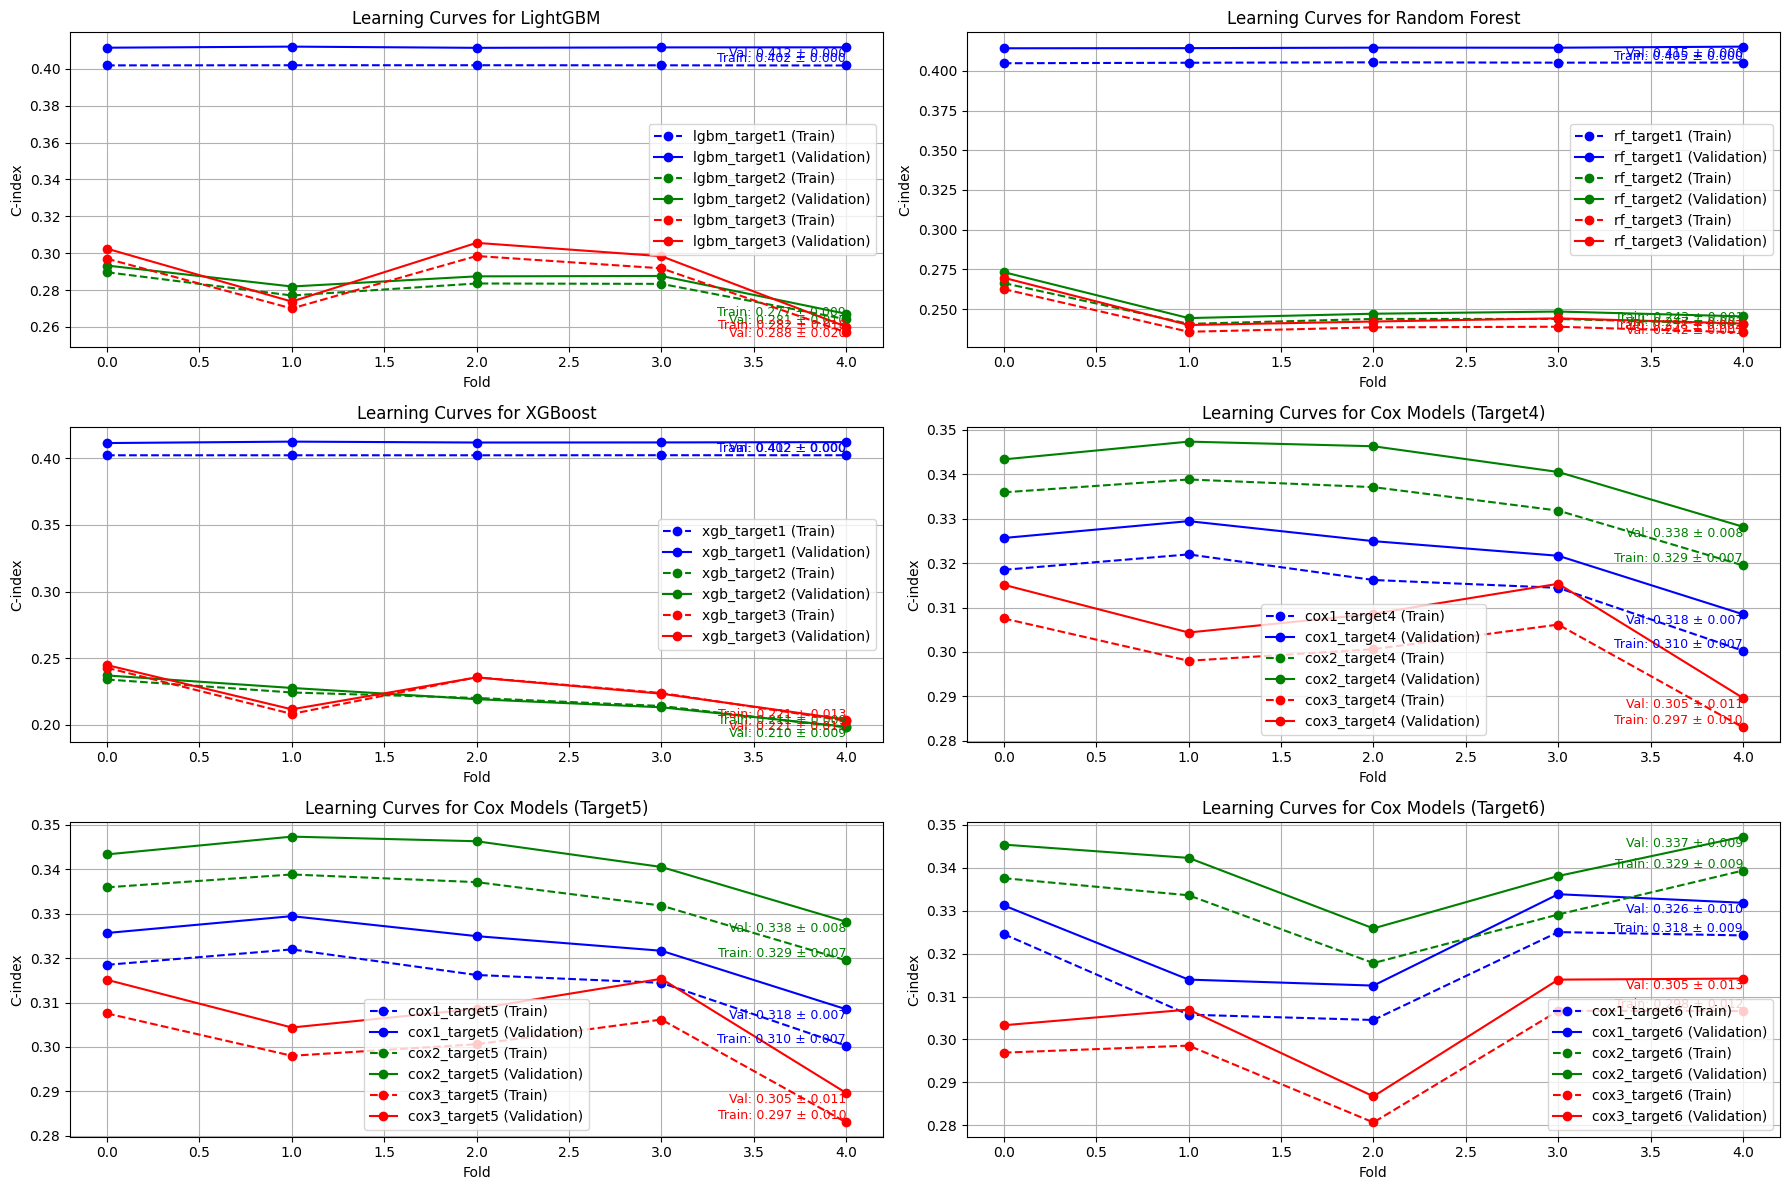

     III.3. For the final ensemble model


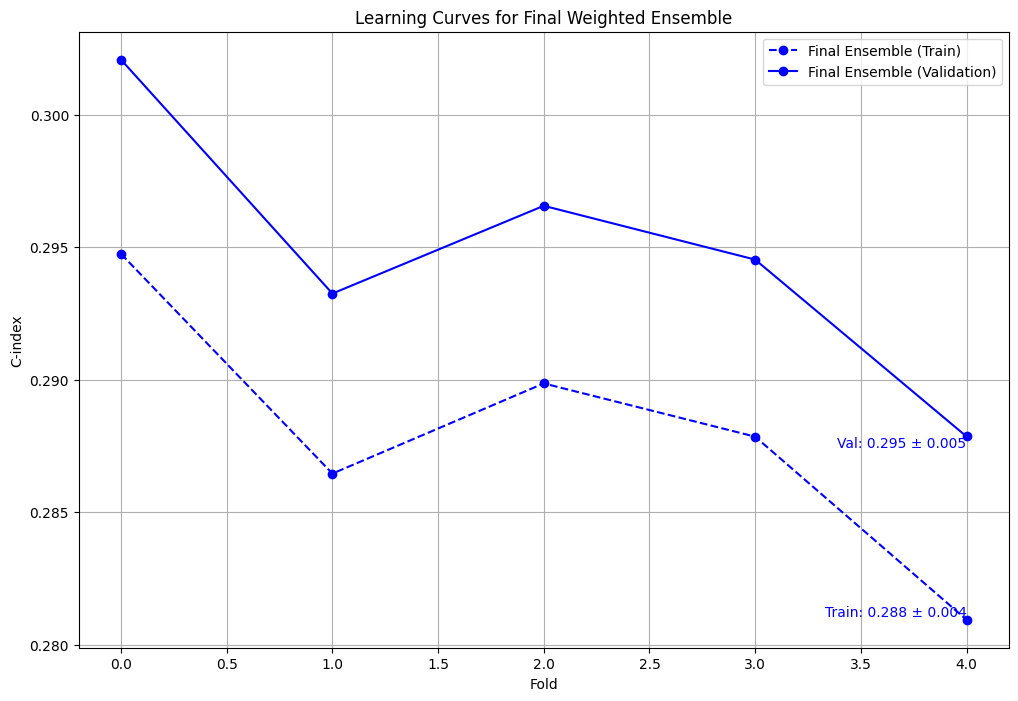


IV. 📊 EVALUATING ON VALIDATION SET USING STRATIFIED C-INDEX ...
     --> Generating ensemble predictions
Stratified C-index: 0.2807170973166057
C-indices by race group: {3: 0.30152587114960616, 1: 0.3010095386954148, 4: 0.287833291125502, 2: 0.2925673307397401, 5: 0.27139387385531727, 0: 0.290370573978451}

V. 🛠️ LOADING AND PREPROCESSING ...
     V.1. Loading and handling missing value in test data
     V.2. Feature Engineering in test data
     V.3.  Scale numerical & encode categorical in test data

V. 🔮 GENERATING PREDICTIONS ON TEST DATA ...
     --> Generating ensemble predictions

VI. 💾 SAVING PREDICTIONS TO SUBMISSION FILE ...
      ID  prediction
0  28800       31.60
1  28801       49.65
2  28802       18.05

✅ Submission file created successfully!


In [12]:
"""Main function to run the survival prediction pipeline."""
config = Config()
preprocessor = DataPreprocessor(config)
model = SurvivalModel(config)

######################################################
# I. LOADING AND PREPROCESSING
######################################################
print("I. 🛠️ LOADING AND PREPROCESSING ...")
print("     I.1. Loading and handling missing value in training data")
train_df = preprocessor.load_data(config.TRAIN_PATH)
train_df = preprocessor.handle_missing_values(train_df)

print("     I.2. Feature Engineering in training data")
feature_engineer = FeatureEngineer(train_df)
train_df = feature_engineer.feature_engineering_pipeline()
train_df = preprocessor.handle_missing_values(train_df)

print("     I.3. Scale numerical & encode categorical in training data")
train_df = preprocessor.scale_numerical(train_df, train=True)
train_df = preprocessor.encode_categorical(train_df, train=True)


######################################################
# II. TRAINING MODEL
######################################################
print("\nII. 🚀 TRAINING MODEL ...")
# Create multiple targets
train_df = model.create_targets(train_df)

# Train models for each target
# LGBM models for targets 1-3
for target_num in range(1, 4):
    X_train, y_train = model.prepare_features(train_df, f'target{target_num}')
    oof_preds = model.train_lgbm(X_train, y_train, train_df['race_group'], f'target{target_num}')
    oof_preds_rf = model.train_rf(X_train, y_train, train_df['race_group'], f'target{target_num}')
    oof_preds_xgb = model.train_xgb(X_train, y_train, train_df['race_group'], f'target{target_num}')

# Train Cox models for target4, target5, and target6
for target_name in ['target4', 'target5', 'target6']:
    X_train, y_train = model.prepare_features(train_df, target_name)
    
    # Train three different Cox models with different parameters
    model.train_cox(X_train, y_train, train_df['race_group'], config.COX1_PARAMS, f'cox1_{target_name}')
    model.train_cox(X_train, y_train, train_df['race_group'], config.COX2_PARAMS, f'cox2_{target_name}')
    model.train_cox(X_train, y_train, train_df['race_group'], config.COX3_PARAMS, f'cox3_{target_name}')

# Optimize ensemble weights
print('     --> Optimizing ensemble weights')
model.optimize_weights(X_train, train_df['efs_time'], train_df['race_group'])


######################################################
# III. PLOT LEARNING CURVES
######################################################
print("\nIII. 🚀 PLOT LEARNING CURVES  ...")
# Split the training data into training and validation sets
print("     III.1. Splitting the training data into training and validation sets")
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4', 'target5', 'target6'], axis=1),
    train_df['efs_time'],  # Use the target variable
    test_size=0.2,  # 20% validation set
    random_state=config.RANDOM_STATE,
    stratify=train_df['race_group']  # Stratify by race_group for fairness
)

print("     III.2. For individual models")
plot_individual_learning_curves(model.models, X_train, y_train, X_val, y_val)
print("     III.3. For the final ensemble model")
plot_final_ensemble_learning_curve(model.models, model.weights, X_train, y_train, X_val, y_val)


######################################################
# IV. EVALUATE ON VALIDATION SET USING STRATIFIED C-INDEX
######################################################
print("\nIV. 📊 EVALUATING ON VALIDATION SET USING STRATIFIED C-INDEX ...")

# Generate predictions on the validation set
val_predictions = model.predict(X_val)

# Calculate the Stratified C-index for the validation set
stratified_c_index_score, c_indices_by_race = stratified_c_index(y_val, val_predictions, X_val['race_group'])

print(f"Stratified C-index: {stratified_c_index_score}")
print(f"C-indices by race group: {c_indices_by_race}")


######################################################
# V. LOADING AND PREPROCESSING TEST DATA
######################################################
print("\nV. 🛠️ LOADING AND PREPROCESSING ...")
print("     V.1. Loading and handling missing value in test data")
test_df = preprocessor.load_data(config.TEST_PATH)
test_df = preprocessor.handle_missing_values(test_df)

print("     V.2. Feature Engineering in test data")
feature_engineer = FeatureEngineer(test_df)
test_df = feature_engineer.feature_engineering_pipeline()
test_df = preprocessor.handle_missing_values(test_df)

print("     V.3.  Scale numerical & encode categorical in test data")
test_df = preprocessor.scale_numerical(test_df, train=False)
test_df = preprocessor.encode_categorical(test_df, train=False)


######################################################
# VI. GENERATING PREDICTIONS ON TEST DATA 
######################################################
print("\nV. 🔮 GENERATING PREDICTIONS ON TEST DATA ...")
X_test = test_df.drop(['ID'], axis=1)
final_predictions = model.predict(X_test)


######################################################
# VII. SAVING PREDICTIONS TO SUBMISSION FILE
######################################################
print("\nVI. 💾 SAVING PREDICTIONS TO SUBMISSION FILE ...")
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'prediction': final_predictions
})
print(submission)
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file created successfully!")

